# Hermes — Run a geometry optimization calculation

In this notebook, we'll perform a Hermes calculation to optimise the geometry of a ligand at the STO-3G Hartree-Fock level of chemical theory.

# 0) Complete example
See the [sample notebook](/Quickstarts/hermes_hartree_fock_energy_calculation-sample.ipynb) for a complete demonstration.

# 1) Setup

## 1.0) Imports

In [68]:
import json
import os
from datetime import datetime
from pathlib import Path
import py3Dmol
import time
import IPython.display
import pandas as pd
import matplotlib.pyplot as plt

import rush

## 1.1) Configuration

In [3]:
EXPERIMENT = "rush-py geo opt demo"
LIGAND = "Menthone"
TAGS = ["qdx", EXPERIMENT, LIGAND]

In [4]:
# |hide
WORK_DIR = Path.home() / "qdx" / EXPERIMENT

if WORK_DIR.exists():
    client = rush.Provider(workspace=WORK_DIR)
    await client.nuke(remote=False)

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(WORK_DIR / ".rush", exist_ok=True)
YOUR_TOKEN = os.getenv("RUSH_TOKEN")
os.chdir(WORK_DIR)

Build our client

In [5]:
os.environ["RUSH_TOKEN"] = YOUR_TOKEN

client = rush.build_blocking_provider_with_functions(batch_tags=TAGS)

# 2) Preparation
We get our ligand into the qdxf format from xyz for conveience (units are in Å)

## 2.0). QDXF to XYZ file conversion helpers

In [47]:
def xyz_to_qdxf_topology(xyz_data):
    symbols = []
    geometry = []
    for line in xyz_data.splitlines()[2:]:
        symbol, x, y, z = line.split()
        symbols.append(symbol)
        geometry.extend([float(x), float(y), float(z)])
    return {
      "schema_version": "0.2.0", 
      "symbols": symbols, 
      "geometry": geometry,
      "fragment_formal_charges": [0]
    }


def qdxf_topology_to_xyz(qdxf_in, name):
    symbols = qdxf_in["symbols"]
    geometry = qdxf_in["geometry"]
    xyz_data = f"{len(symbols)}\n{name}\n"
    for i in range(len(symbols)):
        symbol = symbols[i]
        x, y, z = geometry[3 * i : 3 * i + 3]
        xyz_data += f"  {symbol}"
        for coord in [x, y, z]:
            xyz_data += "     "
            if coord >= 0:
                xyz_data += " "
            xyz_data += f"{(coord):.4f}"
        xyz_data += "\n"
    return xyz_data

## 2.1). Menthone XYZ

In [40]:
menthone_xyz = """29
Menthone
O 0.000000 0.000000 2.558588
C -2.680797 -0.675188 0.263980
C -1.906884 -0.789063 -1.068912
C -0.602098 0.064466 -1.071068
C 0.366909 -0.282183 0.130702
C -0.433287 -0.404398 1.478748
C -1.808494 -1.092292 1.470418
C 0.044065 -0.096564 -2.466944
C 1.677375 0.591559 0.178761
C 2.772719 0.000000 1.089318
C 1.454289 2.072516 0.548719
H -3.035012 0.366317 0.400380
H -3.599144 -1.292723 0.227789
H -1.669128 -1.852863 -1.268519
H -2.572382 -0.477657 -1.897646
H -0.907344 1.125284 -0.965973
H 0.706612 -1.317260 -0.057940
H -2.333932 -0.872569 2.418013
H -1.641652 -2.184271 1.466577
H -0.674781 0.102344 -3.284209
H 0.444399 -1.115561 -2.625554
H 0.876910 0.611365 -2.625751
H 2.123665 0.582983 -0.833314
H 2.486651 0.015826 2.157705
H 3.722633 0.560185 1.006026
H 2.999840 -1.050348 0.830270
H 2.393351 2.654765 0.503419
H 1.052537 2.188312 1.573056
H 0.742979 2.567019 -0.136640
"""

menthone_qdxf_data = xyz_to_qdxf_topology(menthone_xyz)

# write the qdxf file to disk
menthone_qdxf = Path(WORK_DIR) / "menthone.qdxf.json"
with open(menthone_qdxf, "w") as f:
    json.dump(menthone_qdxf_data, f)

## 2.2). Visualisation of Initial Geometry

In [41]:
initial_geo_vis = py3Dmol.view()
initial_geo_vis.addModel(menthone_xyz, "xyz")
initial_geo_vis.setStyle({"stick": {}})
initial_geo_vis.zoomTo()
initial_geo_vis.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# 3) Quantum geometry optimization calculation
We submit our geometry optimization calculation to rush for processing and then inspect the results

## 3.0) Arguments

In [42]:
help(client.hermes_geo_opt)

Help on function hermes_geo_opt in module rush.provider:

hermes_geo_opt(*args: typing_extensions.Unpack[tuple[Record, typing.Optional[Record], typing.Optional[Record], typing.Optional[Record], Record, RushObject[Record]]], target: 'Target | None' = None, resources: 'Resources | None' = None, tags: 'list[str] | None' = None, restore: 'bool | None' = None) -> tuple[RushObject[list[Record]], list[Record]]
    Runs a HERMES energy calculation given a topology, and optionally model and keyword configurations.
    
    Module version:  
    `github:talo/tengu-hermes/ee2d3dcff174e73795a961d1d5fdf805ef601bf8#hermes_geo_opt`
    
    QDX Type Description:
    
        in: System {
            teams_per_node: u32?,
            oversubscribe_gpus: bool?,
            gpus_per_team: u32?,
            max_gpu_memory_mb: u64?
        };
        in: Model {
            basis: string,
            aux_basis: string?,
            standard_orientation: string?,
            force_cartesian_basis_sets: boo

In [43]:
HERMES_RESOURCES = {
    "gpus": 1,
    "storage": 1000,
    "storage_units": "MB",
    "walltime": 60,
}

In [44]:
(topologies,optimisation_frames) = client.hermes_geo_opt(
    {},
    {
        "basis": "STO-3G",
        "aux_basis": "6-31G",
        "method": "RestrictedHF",
        "standard_orientation": "None"
    },  # configuration for a fast converging, low accuracy run
    None,
    None,
    {
        "max_iters" : 30
    },  # simple optimisation keywords, most systems should converge within 30 steps
    menthone_qdxf,
    resources=HERMES_RESOURCES,
)

## 3.1). Visualise the Topology Frames

We create a short animation showing the frames of the optimisation proceedure, in practice the user would normally just take the final frame.

In [48]:
topologies_data = json.load(topologies.download("topologies.json").open())
xyz_frames = []
for topology in topologies_data:
    xyz_frames.append(qdxf_topology_to_xyz(topology, "Menthone"))

2024-07-09 15:02:40,620 - rush - WARNING - File topologies.json already exists in workspace


In [62]:
optimisation_viewer = py3Dmol.view(width=800, height=600)
optimisation_viewer.show()
for frame in xyz_frames:
    optimisation_viewer.removeAllModels()
    optimisation_viewer.addModel(frame, 'xyz')  
    optimisation_viewer.setStyle({'stick': {}}) 
    optimisation_viewer.zoomTo()
    optimisation_viewer.render()
    IPython.display.clear_output(wait=True)
    IPython.display.display(optimisation_viewer.show())
    time.sleep(0.5)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

## 3.2). Plot the energy of the optimisation frames

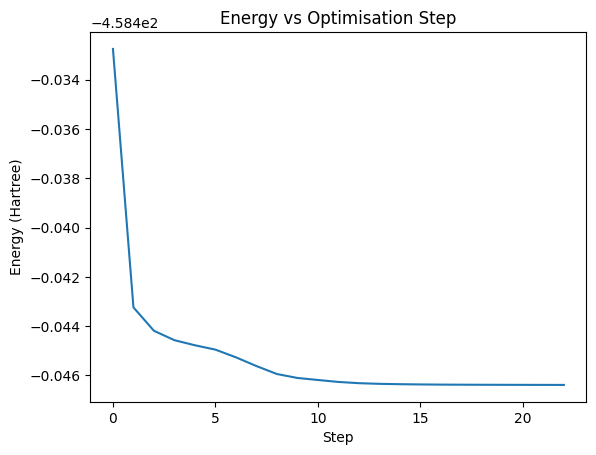

In [74]:
energies = [frame["total_energy"] for frame in optimisation_frames.value]
plt.plot(energies)
plt.title("Energy vs Optimisation Step")
plt.xlabel("Step")
plt.ylabel("Energy (Hartree)")
plt.show()